# Notebook to calculate the rotation of the MIRI images with respect to NIRCam
Let's start with the imports

In [1]:
from astropy.io import fits
from astropy.wcs import WCS
import math
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from scipy.ndimage import rotate

Define functions:

In [2]:
def rotate_image(image, angle):
    """Rotate image by the given angle and resample it."""
    return rotate(image, angle, reshape=True, mode='nearest')

def process_fits(fits_file, output_folder):
    """Process the MIRI FITS file to rotate and save a new aligned FITS file."""
    # Open the FITS file
    with fits.open(fits_file) as hdul:
        # Extract the image data and header
        image_data = hdul[1].data
        header = hdul[1].header
        
        # Extract WCS information from header
        wcs = WCS(header)
        
        # Check if the PC matrix exists and extract rotation angle
        if 'PC1_1' in header and 'PC2_2' in header:
            # Calculate the rotation angle from the PC matrix
            pc_matrix = np.array([[header['PC1_1'], header['PC1_2']], 
                                  [header['PC2_1'], header['PC2_2']]])
            angle = np.arctan2(pc_matrix[1, 0], pc_matrix[0, 0]) * 180 / np.pi
        else:
            print("No PC matrix found, assuming no rotation")
            angle = 0

        # Rotate the image to align the Y-axis with North
        rotated_image = rotate_image(image_data, -angle)
        
        # Plot the original and rotated images
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        axs[0].imshow(image_data, cmap='gray')
        axs[0].set_title('Original Image')
        axs[1].imshow(rotated_image, cmap='gray')
        axs[1].set_title('Rotated Image')
        plt.show()
        
        # Create new header for rotated image
        new_header = header.copy()
        
        # Remove PC matrix to indicate the image is now aligned
        if 'PC1_1' in new_header:
            del new_header['PC1_1']
            del new_header['PC1_2']
            del new_header['PC2_1']
            del new_header['PC2_2']
        
        # Create a new HDU with the rotated image
        new_hdu = fits.ImageHDU(rotated_image, header=new_header)
        
        # Create the output folder if it doesn't exist
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        
        # Create the output filename and save the new FITS file
        output_filename = os.path.join(output_folder, os.path.basename(fits_file))
        new_hdu.writeto(output_filename, overwrite=True)
        print(f"Rotated image saved as: {output_filename}")

Found 4 FITS files.
Found 164 FITS files.
Filename: ./cutouts/7102_F770W_cutout_primer.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     352   ()      
  1                1 ImageHDU        38   (48, 48)   float32   
No CD matrix found in the header.
WCS Information:
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 150.07411392406 2.2685156967128 
CRPIX : -269.70055124911 744.41823702792 
PC1_1 PC1_2  : -0.45139107874244 -0.89232622623777 
PC2_1 PC2_2  : -0.89232622623777 0.45139107874244 
CDELT : 3.0812611336492e-05 3.0812611336492e-05 
NAXIS : 48  48
Axis 1:
  Coordinate type: RA---TAN
  Reference pixel: -269.70055124911
  Reference value: 150.07411392406
  Pixel scale: 3.0812611336492e-05
Axis 2:
  Coordinate type: DEC--TAN
  Reference pixel: 744.41823702792
  Reference value: 2.2685156967128
  Pixel scale: 3.0812611336492e-05
PC matrix:
PC1_1 = -0.45139107874244
PC1_2 = -0.89232622623777
PC2_1 = -0.892326

Set OBSGEO-B to     8.121531 from OBSGEO-[XYZ].
Set OBSGEO-H to 1684160522.172 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


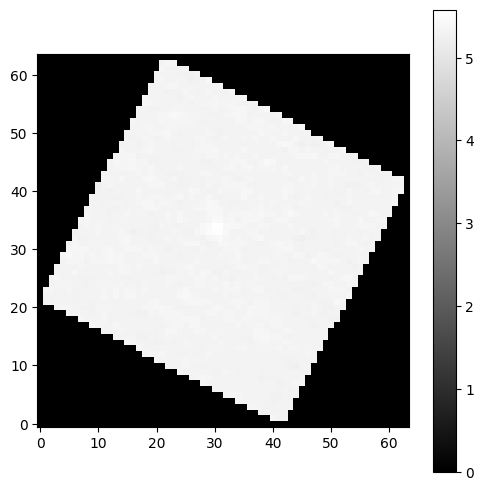

In [3]:

# Load datasets
primer = '/home/bpc/University/master/Red_Cardinal/MIRI/PRIMER/'
primer_data = glob.glob(os.path.join(primer, "*.fits"))
print(f"Found {len(primer_data)} FITS files.")

cweb = "/home/bpc/University/master/Red_Cardinal/MIRI/COSMOS-Web/"
cweb_data = glob.glob(os.path.join(cweb, "*.fits"))
print(f"Found {len(cweb_data)} FITS files.")

# Create output directory
output_dir = "./rotated/"
os.makedirs(output_dir, exist_ok=True)

cutout_name =  f"./cutouts/7102_F770W_cutout_primer.fits"

with fits.open(cutout_name) as hdu:
    hdu.info()
    data = hdu[1].data
    #header = hdu[1].header
    #wcs = WCS(header)
    # Open the MIRI FITS file
    miri_header = hdu[1].header

    # Extract WCS
    miri_wcs = WCS(miri_header)

# Check for CD matrix (if present)
if 'CD1_1' in miri_header and 'CD1_2' in miri_header:
    CD1_1 = miri_header['CD1_1']
    CD1_2 = miri_header['CD1_2']
    CD2_1 = miri_header['CD2_1']
    CD2_2 = miri_header['CD2_2']
    
    # Calculate the rotation angle (in radians)
    rotation_angle = math.atan2(CD1_2, CD1_1)
    
    # Convert the angle to degrees
    rotation_angle_deg = math.degrees(rotation_angle)
    
    print(f"Rotation angle: {rotation_angle_deg} degrees")
else:
    print("No CD matrix found in the header.")


# Inspect WCS parameters
print("WCS Information:")
print(miri_wcs)

# Get the WCS axes and check the orientation information
for axis in range(miri_wcs.naxis):
    print(f"Axis {axis+1}:")
    print(f"  Coordinate type: {miri_wcs.wcs.ctype[axis]}")
    print(f"  Reference pixel: {miri_wcs.wcs.crpix[axis]}")
    print(f"  Reference value: {miri_wcs.wcs.crval[axis]}")
    print(f"  Pixel scale: {miri_wcs.wcs.cdelt[axis]}")

# Check if CROT or PC matrix is present
if 'CROT' in miri_header:
    print(f"CROT found: {miri_header['CROT']}")
elif 'PC1_1' in miri_header:
    print("PC matrix:")
    print(f"PC1_1 = {miri_header['PC1_1']}")
    print(f"PC1_2 = {miri_header['PC1_2']}")
    print(f"PC2_1 = {miri_header['PC2_1']}")
    print(f"PC2_2 = {miri_header['PC2_2']}")
else:
    print("No rotation matrix (CROT or PC matrix) found in the header.")
    
# PC matrix elements
pc1_1 = -0.45139107874244
pc2_1 = -0.89232622623777

# Calculate the rotation angle in radians
theta_rad = np.arctan2(pc2_1, pc1_1)

# Convert to degrees
theta_deg = np.degrees(theta_rad)

# Display the result
print(f"Rotation angle: {theta_deg} degrees")

# Assuming 'miri_image' is the 2D numpy array of the MIRI image
rotated_miri_image = rotate(data, -theta_deg, reshape=True)
# Save the cutout
plt.figure(figsize=(6, 6))
plt.imshow(rotated_miri_image, origin='lower', cmap='gray')
plt.colorbar()
plt.show()
